### mini-ensemble of CESM2-4p2z historical + ssp370

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

#import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

#import cftime
import matplotlib.colors as colors
import utils

###  specify desired variables

In [2]:
variables = ['photoC_TOT_zint_100m','POC_FLUX_100m','IFRAC']

### Grab the first ensemble member (002) - this one goes from 1850 to 2014 (hist) and 2015 to 2100 (ssp)

#### Get historical part

In [3]:
case = 'b.e21p4.BHIST.f09_g17.4p2z.002'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/' + case + '/ocn/proc/tseries/month_1/'

In [4]:
ds_hist = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))  
    
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds_hist = xr.merge([ds_hist,ds_tmp],combine_attrs='override')

starting on  photoC_TOT_zint_100m
starting on  POC_FLUX_100m
starting on  IFRAC


#### Get future part

In [5]:
case = 'b.e21p4.BSSP370.f09_g17.4p2z.002'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/' + case + '/ocn/proc/tseries/month_1/'

In [6]:
ds_ssp = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))  
    
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True) #, preprocess=preprocess)
    
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds_ssp = xr.merge([ds_ssp,ds_tmp],combine_attrs='override')

starting on  photoC_TOT_zint_100m
starting on  POC_FLUX_100m
starting on  IFRAC


### concat hist and ssp

In [7]:
ds1 = xr.concat([ds_hist,ds_ssp],dim='time')

### Now grab ensemble members 003, 004, 005, 006

In [8]:
cases_hist = ['b.e21p5.BHIST.f09_g17.4p2z.003','b.e21p5.BHIST.f09_g17.4p2z.004','b.e21p5.BHIST.f09_g17.4p2z.005','b.e21p5.BHIST.f09_g17.4p2z.006']
cases_ssp = ['b.e21p5.BSSP370.f09_g17.4p2z.003','b.e21p5.BSSP370.f09_g17.4p2z.004','b.e21p5.BSSP370.f09_g17.4p2z.005','b.e21p5.BSSP370.f09_g17.4p2z.006']

In [9]:
#ds2 will be the dataset with variables dims nlon,nlat,time,member_id


for i in [0,1,2,3]:

    ### first grab historical part of this ensemble member
    ds_hist = xr.Dataset()

    path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/' + cases_hist[i] + '/ocn/proc/tseries/month_1/'
    
    for var in variables:
    
        print('starting on ', var)
        print('path:', path)
        
        ################ FOSI
        
        files = sorted(glob(f'{path}/{cases_hist[i]}.pop.h.{var}.??????-??????.nc'))  
        
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                           drop_variables=["transport_components", "transport_regions"], decode_times=True) #, preprocess=preprocess)
        
        keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]
    
        ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
        ds_hist = xr.merge([ds_hist,ds_tmp],combine_attrs='override')

    #### now grab the ssp part of this ensemble member
    ds_ssp = xr.Dataset()
    
    path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/' + cases_ssp[i] + '/ocn/proc/tseries/month_1/'

    for var in variables:
        
        print('starting on ', var)
        ################ FOSI
        
        files = sorted(glob(f'{path}/{cases_ssp[i]}.pop.h.{var}.??????-??????.nc'))  
        
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                           drop_variables=["transport_components", "transport_regions"], decode_times=True)
        
        
        keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]
    
        ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
        ds_ssp = xr.merge([ds_ssp,ds_tmp],combine_attrs='override')

    ds_tmp = xr.concat([ds_hist,ds_ssp],dim='time')

    if i == 0:
        ds2 = ds_tmp
    else:
        ds2 = xr.concat([ds2,ds_tmp],dim='member_id')


starting on  photoC_TOT_zint_100m
path: /glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/b.e21p5.BHIST.f09_g17.4p2z.003/ocn/proc/tseries/month_1/
starting on  POC_FLUX_100m
path: /glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/b.e21p5.BHIST.f09_g17.4p2z.003/ocn/proc/tseries/month_1/
starting on  IFRAC
path: /glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/b.e21p5.BHIST.f09_g17.4p2z.003/ocn/proc/tseries/month_1/
starting on  photoC_TOT_zint_100m
starting on  POC_FLUX_100m
starting on  IFRAC
starting on  photoC_TOT_zint_100m
path: /glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/b.e21p5.BHIST.f09_g17.4p2z.004/ocn/proc/tseries/month_1/
starting on  POC_FLUX_100m
path: /glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like-run/b.e21p5.BHIST.f09_g17.4p2z.004/ocn/proc/tseries/month_1/
starting on  IFRAC
path: /glade/campaign/cesm/development/bgcwg/projects/CESM2-4p2z-CMIP6-like

### fix the time dimension and then trim them so they both start in 1920

In [10]:
ds2.time[48:2220]

<xarray.DataArray 'time' (time: 2172)>
array([cftime.DatetimeNoLeap(1920, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1920-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound

In [11]:
ds2 = ds2.isel(time=slice(48,2220))

In [12]:
ds1.time[840:3012]

<xarray.DataArray 'time' (time: 2172)>
array([cftime.DatetimeNoLeap(1920, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1920-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound

In [13]:
ds1 = ds1.isel(time=slice(840,3012))

In [14]:
ds1['time'] = ds1.time_bound.compute().mean(dim="d2")

In [15]:
ds2['time'] = ds1.time

In [16]:
ds1.time

<xarray.DataArray 'time' (time: 2172)>
array([cftime.DatetimeNoLeap(1920, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1920-01-16 12:00:00 ... 2100-12-16 12:00:00

### Now both datasets are the same length, so let's try merging them, creating a 'member_id' dimension

In [17]:
ds = xr.concat([ds1,ds2],dim='member_id')

In [18]:
ds

<xarray.Dataset>
Dimensions:               (d2: 2, member_id: 5, nlat: 384, nlon: 320, time: 2172, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    TLONG                 (member_id, nlat, nlon) float64 320.6 321.7 ... 319.8
    TLAT                  (member_id, nlat, nlon) float64 -79.22 ... 72.19
  * time                  (time) object 1920-01-16 12:00:00 ... 2100-12-16 12...
Dimensions without coordinates: d2, member_id, nlat, nlon
Data variables:
    dz                    (time, z_t, member_id) float32 dask.array<chunksize=(1140, 60, 1), meta=np.ndarray>
    time_bound            (time, d2, member_id) object dask.array<chunksize=(360, 2, 1), meta=np.ndarray>
    photoC_TOT_zint_100m  (time, nlat, nlon, member_id) float32 dask.array<chunksize=(360, 384, 320, 1), meta=np.ndarray>
    POC_FLUX_100m         (time, nlat, nlon, member_id) float32 dask.array<chunksize=(360, 384, 320, 1), meta=np.ndarray>
    IFRAC                 (time, nlat, nlon, member_id) float32 dask.array<chunksize=(360, 384, 320, 1), meta=np.ndarray>

### clean things up a bit

In [19]:
ds['TLONG'] = ds.TLONG.isel(member_id=0).squeeze()
ds['TLAT'] = ds.TLAT.isel(member_id=0).squeeze()

In [20]:
ds

<xarray.Dataset>
Dimensions:               (d2: 2, member_id: 5, nlat: 384, nlon: 320, time: 2172, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
    TLONG                 (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
    TLAT                  (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
  * time                  (time) object 1920-01-16 12:00:00 ... 2100-12-16 12...
Dimensions without coordinates: d2, member_id, nlat, nlon
Data variables:
    dz                    (time, z_t, member_id) float32 dask.array<chunksize=(1140, 60, 1), meta=np.ndarray>
    time_bound            (time, d2, member_id) object dask.array<chunksize=(360, 2, 1), meta=np.ndarray>
    photoC_TOT_zint_100m  (time, nlat, nlon, member_id) float32 dask.array<chunksize=(360, 384, 320, 1), meta=np.ndarray>
    POC_FLUX_100m         (time, nlat, nlon, member_id) float32 dask.array<chunksize=(360, 384, 320, 1), meta=np.ndarray>
    IFRAC                 (time, nlat, nlon, member_id) float32 dask.array<chunksize=(360, 384, 320, 1), meta=np.ndarray>

### Now spin up a cluster and do some analysis

In [21]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='05:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [22]:
cluster, client = get_ClusterClient()
cluster.scale(18) 
client

Client Scheduler: tcp://128.117.208.109:36361 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### get coords and make a ones array for masking

In [23]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
area_m = area * 1.e-4
area_km = area * 1.e-10
lons_norm = utils.normal_lons(lons)

In [24]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [25]:
ds.time

<xarray.DataArray 'time' (time: 2172)>
array([cftime.DatetimeNoLeap(1920, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1920, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1920-01-16 12:00:00 ... 2100-12-16 12:00:00

### Create a SIZ mask using seasonal average JJA (I'll make DJF and SON too, just in case)

In [26]:
ds_djf = xr.Dataset()
ds_jja = xr.Dataset() # for calculating SIZ mask, whether or not the wintertime ifrac makes a big difference for the following growing season
ds_son = xr.Dataset()

sp = 8 # sept index , rearing period (rp)
i = 5 # june index for jja averages
s = 11 #december index for djf averages, summer (s)

for year in np.arange(0,180,1):
        
        print(year+1920,sp,s,i)
    
        
        ### JJA
        jja = ds.isel(time=slice(i,i+3)).mean(dim='time')

        ds_jja = xr.concat([ds_jja,jja],dim='time')

        i = i + 12
        
                
        ### SON
        son = ds.isel(time=slice(sp,sp+3)).mean(dim='time')

        ds_son = xr.concat([ds_son,son],dim='time')

        sp = sp + 12
        
                        
        ### DJF
        djf = ds.isel(time=slice(s,s+3)).mean(dim='time')

        ds_djf = xr.concat([ds_djf,djf],dim='time')

        s = s + 12


# ### slice off the first timeslice (if you are using a recent version of xarray)!!!!
# ds_djf = ds_djf.isel(time=slice(1,181))
# ds_son = ds_son.isel(time=slice(1,181))
# ds_jja = ds_jja.isel(time=slice(1,181))


ds_djf['time'] = np.arange(1920,2100,1)
ds_son['time'] = np.arange(1920,2100,1)
ds_jja['time'] = np.arange(1920,2100,1)

1920 8 11 5
1921 20 23 17
1922 32 35 29
1923 44 47 41
1924 56 59 53
1925 68 71 65
1926 80 83 77
1927 92 95 89
1928 104 107 101
1929 116 119 113
1930 128 131 125
1931 140 143 137
1932 152 155 149
1933 164 167 161
1934 176 179 173
1935 188 191 185
1936 200 203 197
1937 212 215 209
1938 224 227 221
1939 236 239 233
1940 248 251 245
1941 260 263 257
1942 272 275 269
1943 284 287 281
1944 296 299 293
1945 308 311 305
1946 320 323 317
1947 332 335 329
1948 344 347 341
1949 356 359 353
1950 368 371 365
1951 380 383 377
1952 392 395 389
1953 404 407 401
1954 416 419 413
1955 428 431 425
1956 440 443 437
1957 452 455 449
1958 464 467 461
1959 476 479 473
1960 488 491 485
1961 500 503 497
1962 512 515 509
1963 524 527 521
1964 536 539 533
1965 548 551 545
1966 560 563 557
1967 572 575 569
1968 584 587 581
1969 596 599 593
1970 608 611 605
1971 620 623 617
1972 632 635 629
1973 644 647 641
1974 656 659 653
1975 668 671 665
1976 680 683 677
1977 692 695 689
1978 704 707 701
1979 716 719 713
1980 7

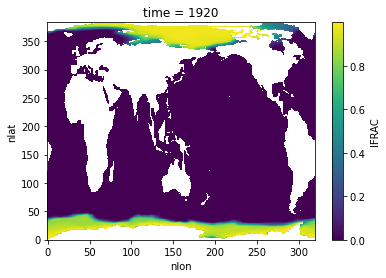

In [27]:
ds_son.IFRAC.isel(time=0).mean(dim='member_id').plot()

### Let's make some timeseries figure, just use SIZ as as example mask

#### define Antarctic SIZ as JJA ifrac > 0.85 over the mean over the first 10 years of the run (1920-1929)

In [28]:
SIZ_mask = ones.where(ds_jja.IFRAC.isel(time=slice(0,10)).mean(dim=('time','member_id')) > 0.85).where(lats<0)

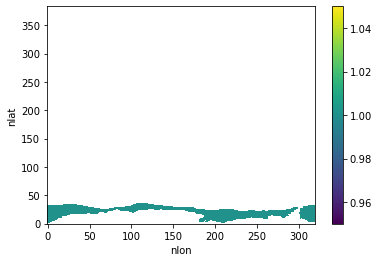

In [29]:
SIZ_mask.plot()

In [30]:
ts_siz_djf = xr.Dataset()
ts_siz_son = xr.Dataset()
ts_siz_jja = xr.Dataset()


for var in variables:
    
    print(var)

    masked_area = area.where(SIZ_mask==1)

    ### DJF
    masked_var = ds_djf[var].where(SIZ_mask==1)
    ts_siz_djf[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    ### SON
    masked_var = ds_son[var].where(SIZ_mask==1)
    ts_siz_son[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    ### SON
    masked_var = ds_jja[var].where(SIZ_mask==1)
    ts_siz_jja[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

photoC_TOT_zint_100m
POC_FLUX_100m
IFRAC


In [31]:
ts_siz_djf['time'] = np.arange(1920,2100,1)
ts_siz_son['time'] = np.arange(1920,2100,1)
ts_siz_jja['time'] = np.arange(1920,2100,1)

In [32]:
ts_siz_djf = ts_siz_djf.load()
ts_siz_son = ts_siz_son.load()
ts_siz_jja = ts_siz_jja.load()

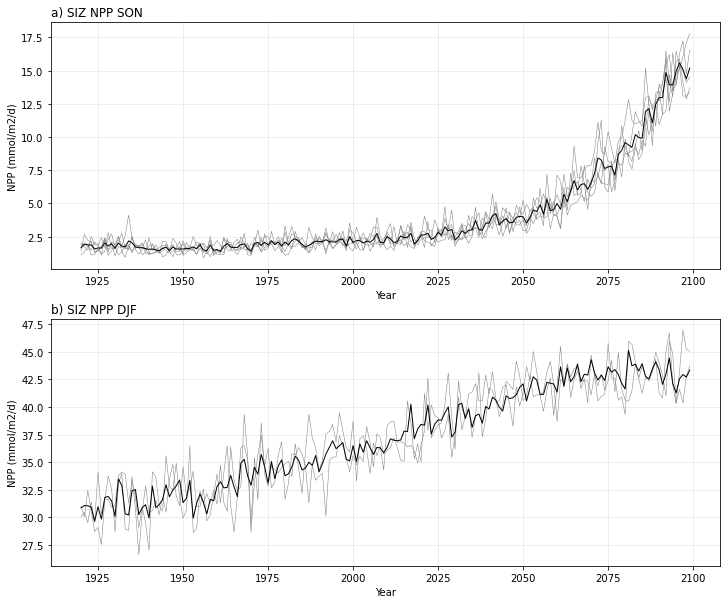

In [36]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(2,1,1)
ax.set_title('a) SIZ NPP SON', loc='left')

for mem in np.arange(0,5,1):
    ax.plot(ts_siz_son['time'], ts_siz_son['photoC_TOT_zint_100m'].isel(member_id=mem)*86400.*0.01,linewidth=0.5,color='gray')
    
ax.plot(ts_siz_son['time'], ts_siz_son['photoC_TOT_zint_100m'].mean(dim='member_id')*86400.*0.01,linewidth=1,color='black')
        
ax.set(ylabel='NPP (mmol/m2/d)',xlabel='Year');
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
#############################3
ax = fig.add_subplot(2,1,2)
ax.set_title('b) SIZ NPP DJF', loc='left')

for mem in np.arange(0,2,1):
    ax.plot(ts_siz_djf['time'], ts_siz_djf['photoC_TOT_zint_100m'].isel(member_id=mem)*86400.*0.01,linewidth=0.5,color='gray')
    
ax.plot(ts_siz_djf['time'], ts_siz_djf['photoC_TOT_zint_100m'].mean(dim='member_id')*86400.*0.01,linewidth=1,color='black')
        
ax.set(ylabel='NPP (mmol/m2/d)',xlabel='Year');
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');

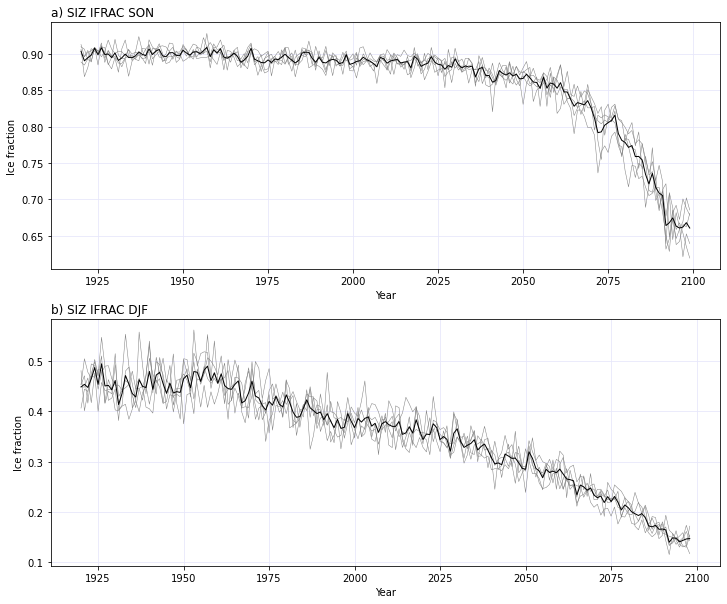

In [37]:
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(2,1,1)
ax.set_title('a) SIZ IFRAC SON', loc='left')

for mem in np.arange(0,5,1):
    ax.plot(ts_siz_son['time'], ts_siz_son['IFRAC'].isel(member_id=mem),linewidth=0.5,color='gray')
    
ax.plot(ts_siz_son['time'], ts_siz_son['IFRAC'].mean(dim='member_id'),linewidth=1,color='black')
        
ax.set(ylabel='Ice fraction',xlabel='Year');
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
################
ax = fig.add_subplot(2,1,2)
ax.set_title('b) SIZ IFRAC DJF', loc='left')

for mem in np.arange(0,5,1):
    ax.plot(ts_siz_djf['time'].isel(time=slice(0,179)), ts_siz_djf['IFRAC'].isel(member_id=mem).isel(time=slice(0,179)),linewidth=0.5,color='gray')
    
ax.plot(ts_siz_djf['time'].isel(time=slice(0,179)), ts_siz_djf['IFRAC'].mean(dim='member_id').isel(time=slice(0,179)),linewidth=1,color='black')
        
ax.set(ylabel='Ice fraction',xlabel='Year');
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');

### DJF sea ice appears to be drifting a lot after 1975, and NPP responds by increasing... hmmmmm

### Make a change map from 1920s to 2090s

In [38]:
ds1 = ds.isel(time=slice(0,120)).mean(dim='time')

In [39]:
ds2 = ds.isel(time=slice(2040,2160)).mean(dim='time')

In [40]:
ds_jja.time[170]

<xarray.DataArray 'time' ()>
array(2090)
Coordinates:
    time     int64 2090

In [41]:
ifrac_jja_1920s = ds_jja.IFRAC.isel(time=slice(0,10)).mean(dim='time')

In [42]:
ifrac_jja_2090s = ds_jja.IFRAC.isel(time=slice(170,180)).mean(dim='time')

In [43]:
ds_diff = ds2 - ds1

In [44]:
ds_diff = ds_diff.load()

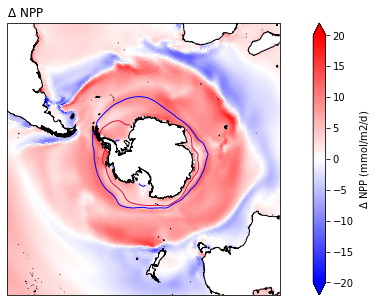

In [45]:
fig = plt.figure(figsize=(12,5))

############### 
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('${\Delta}$ NPP', loc='left')


lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_diff.photoC_TOT_zint_100m.mean(dim='member_id') *86400.*0.01)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',vmin=-20,vmax=20)

#### add SIZ contour 1920s
ice_lev = [0.85]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ifrac_jja_1920s.mean(dim='member_id'))
cs = ax.contour(lon,lat,field, colors='blue',
                levels = ice_lev,
                linewidths = 1,
                transform=ccrs.PlateCarree())

#### add SIZ contour 2090s
ice_lev = [0.85]
lon,lat,field = utils.adjust_pop_grid(lons, lats, ifrac_jja_2090s.mean(dim='member_id'))
cs = ax.contour(lon,lat,field, colors='crimson',
                levels = ice_lev,
                linewidths = 1,
                transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)
fig.colorbar(pc,extend='both', label='${\Delta}$ NPP (mmol/m2/d)');

### Make a couple climatologies

In [46]:
ds_clim1 = ds.isel(time=slice(0,120)).groupby('time.month').mean('time')
ds_clim2 = ds.isel(time=slice(2040,2160)).groupby('time.month').mean('time')

In [47]:
ds_clim1 = ds_clim1.load()
ds_clim2 = ds_clim2.load()

In [48]:
ts_siz_clim1920s = xr.Dataset()
ts_siz_clim2090s = xr.Dataset()


for var in variables:
    
    print(var)

    masked_area = area.where(SIZ_mask==1)

    ### 1920s
    masked_var = ds_clim1[var].where(SIZ_mask==1)
    ts_siz_clim1920s[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    ### 2090s
    masked_var = ds_clim2[var].where(SIZ_mask==1)
    ts_siz_clim2090s[var] = (masked_var * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

photoC_TOT_zint_100m
POC_FLUX_100m
IFRAC


In [49]:
ts_siz_clim2090s

<xarray.Dataset>
Dimensions:               (member_id: 5, month: 12)
Coordinates:
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: member_id
Data variables:
    photoC_TOT_zint_100m  (month, member_id) float64 dask.array<chunksize=(12, 5), meta=np.ndarray>
    POC_FLUX_100m         (month, member_id) float64 dask.array<chunksize=(12, 5), meta=np.ndarray>
    IFRAC                 (month, member_id) float64 dask.array<chunksize=(12, 5), meta=np.ndarray>

In [50]:
ts_siz_clim1920s = xr.concat([ts_siz_clim1920s,ts_siz_clim1920s.isel(month=slice(0,6))],dim='month')
ts_siz_clim2090s = xr.concat([ts_siz_clim2090s,ts_siz_clim2090s.isel(month=slice(0,6))],dim='month')

In [51]:
xvals = [7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,18]

xlabels = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']

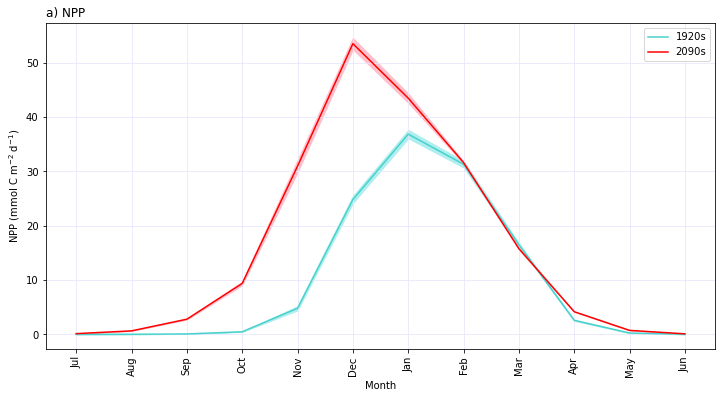

In [52]:
fig = plt.figure(figsize=(12,6))

convert=0.01*86400

ax1 = fig.add_subplot(1,1,1)
ax1.set_title('a) NPP',fontsize=12,loc='left')
ax1.set_ylabel('NPP (mmol C m$^{-2}$ d$^{-1}$)')
ax1.set_xlabel('Month')
#ax1.set_ylim(20,180)
ax1.xaxis.grid(True, which='major',color='lavender')
ax1.yaxis.grid(False, which='major',color='lavender')
#plot 1920
ax1.plot(xvals,ts_siz_clim1920s['photoC_TOT_zint_100m'].mean(dim='member_id').isel(month=slice(6,18))*convert, 
         color='mediumturquoise', label='1920s', lw=1.5)
error = ts_siz_clim1920s['photoC_TOT_zint_100m'].std(dim='member_id').isel(month=slice(6,18))*convert
ax1.fill_between(xvals, ts_siz_clim1920s['photoC_TOT_zint_100m'].mean(dim='member_id').isel(month=slice(6,18))*convert-error, 
                 ts_siz_clim1920s['photoC_TOT_zint_100m'].mean(dim='member_id').isel(month=slice(6,18))*convert+error,color='paleturquoise')


#plot 2090s
ax1.plot(xvals,ts_siz_clim2090s['photoC_TOT_zint_100m'].mean(dim='member_id').isel(month=slice(6,18))*convert, 
         color='red', label='2090s', lw=1.5)
error = ts_siz_clim2090s['photoC_TOT_zint_100m'].std(dim='member_id').isel(month=slice(6,18))*convert
ax1.fill_between(xvals, ts_siz_clim2090s['photoC_TOT_zint_100m'].mean(dim='member_id').isel(month=slice(6,18))*convert-error, 
                 ts_siz_clim2090s['photoC_TOT_zint_100m'].mean(dim='member_id').isel(month=slice(6,18))*convert+error,color='pink')

plt.xticks(xvals, xlabels, rotation='vertical')
ax1.legend();